<a href="https://colab.research.google.com/github/vachaconcu/Mineriadatos/blob/master/Raza_Segunda_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segundo entrenamiento - Modelo Resnet para clasificación de Raza


En el código siguiente se importan las funciones necesarias, principalmente de tensorflow.keras

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import tarfile
from skimage import data
from os import remove
from skimage.color import rgb2gray

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from sklearn.model_selection import train_test_split
from google.colab import files
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape,ZeroPadding2D,Activation,MaxPooling2D,Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SpatialDropout2D
from matplotlib import pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D , Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
from numpy import load
import os

Ahora se importan los datos que ya están en forma de tensores y separados en datos de entrenamiento, validación interna y validación externa.

Los datos de etiqueta ya se encuentran en codificación one-hot donde los niveles de raza son: Blanco [10000], Negro [01000], Asiático [00100], Indio [00010], Otro [00001].

In [5]:
import os
os.chdir('/content/drive/My Drive/Mineria/Interna/datos/Modelos')

datos= load('/content/drive/My Drive/Mineria/Interna/datos/X_R_val_int.npz') ; x_test = datos['arr_0']
datos= load('/content/drive/My Drive/Mineria/Interna/datos/X_R_train.npz') ; x_train = datos['arr_0']
datos= load('/content/drive/My Drive/Mineria/Interna/datos/y_R_val_int.npz') ; y_test = datos['arr_0']
datos= load('/content/drive/My Drive/Mineria/Interna/datos/y_R_train.npz') ; y_train = datos['arr_0']

datos= load('/content/drive/My Drive/Mineria/Interna/datos/y_R_val_ext.npz') ; y_test2 = datos['arr_0']
datos= load('/content/drive/My Drive/Mineria/Interna/datos/X_R_val_ext.npz') ; x_test2 = datos['arr_0']

Se imprimen los tamaños de los conjuntos de datos correspondientes:

In [ ]:
print('x_test =',x_test.shape)
print('x_train =',x_train.shape)
print('y_test =',y_test.shape)
print('y_train =',y_train.shape)

print('y_test_ext=', y_test2.shape)
print('x_test_ext=', x_test2.shape)

x_test = (1719, 200, 200, 3)
x_train = (6874, 200, 200, 3)
y_test = (1719, 5)
y_train = (6874, 5)
y_test_ext= (2063, 5)
x_test_ext= (2063, 200, 200, 3)


# Arquitectura ResNet v2 
El número de clases se establece como 5 ya que las clasificaciones posibles son Blanco, Negro, Asiático, Indio y otro. Adicionalmente se usa un dropout de 0.1

In [ ]:
batch_size = 32 
epochs = 30

data_augmentation = True
num_classes = 5
subtract_pixel_mean = True

n = 2
version = 2
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

model_type = 'ResNet%dv%d' % (depth, version)
model_type

'ResNet20v2'

In [ ]:
input_shape = x_train.shape[1:]

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (6874, 200, 200, 3)
6874 train samples
1719 test samples
y_train shape: (6874, 5)


In [ ]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 dropout=0.4,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
            x = Dropout(dropout)(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
            x = Dropout(dropout)(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_v2(input_shape, depth, num_classes=5, dropout=0.4):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 110 in [b])')
    
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)
    inputs = Input(shape=input_shape)
    
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                
                if res_block == 0:  
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                
                if res_block == 0:
                    
                    strides = 2 

            
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])

        num_filters_in = num_filters_out

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)


    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
plot_model(model, to_file="%s.png" % model_type, show_shapes=True)
print(model_type)

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 200, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 200, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 200, 200, 16) 0           batch_normalization[0][0]        
________________________________________________________________________

In [ ]:
#using last check point
from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/Mineria/Interna/datos/Modelos/Raza_0.3_ResNet20v2_model.076.h5')

In [ ]:
save_dir = os.path.join(os.getcwd(), './Modelos')
model_name = 'Raza_Segunda_vale_0.1_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    
    datagen = ImageDataGenerator(
        
        featurewise_center=False,
        
        samplewise_center=False,
        
        featurewise_std_normalization=False,
        
        samplewise_std_normalization=False,
        
        zca_whitening=False,
        
        rotation_range=0,
        
        width_shift_range=0.1,
        
        height_shift_range=0.1,
        
        horizontal_flip=True,
        
        vertical_flip=False)

    
    datagen.fit(x_train)

    
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, 
                        steps_per_epoch=len(x_train)//batch_size,
                        callbacks=callbacks)

Using real-time data augmentation.
Learning rate:  0.001
Epoch 1/30
214/214 [==============================] - ETA: 0s - loss: 0.7338 - accuracy: 0.7701
Epoch 00001: val_accuracy improved from -inf to 0.70099, saving model to /content/drive/.shortcut-targets-by-id/1EIw6ZmKwlGHMh1CQuZhn85QTdh7-YF5_/Interna/datos/Modelos/./Modelos/Raza_Segunda_vale_0.1_ResNet20v2_model.001.h5
214/214 [==============================] - 237s 1s/step - loss: 0.7338 - accuracy: 0.7701 - val_loss: 1.0264 - val_accuracy: 0.7010 - lr: 0.0010
Learning rate:  0.001
Epoch 2/30
214/214 [==============================] - ETA: 0s - loss: 0.7246 - accuracy: 0.7751
Epoch 00002: val_accuracy improved from 0.70099 to 0.75509, saving model to /content/drive/.shortcut-targets-by-id/1EIw6ZmKwlGHMh1CQuZhn85QTdh7-YF5_/Interna/datos/Modelos/./Modelos/Raza_Segunda_vale_0.1_ResNet20v2_model.002.h5
214/214 [==============================] - 232s 1s/step - loss: 0.7246 - accuracy: 0.7751 - val_loss: 0.8777 - val_accuracy: 0.7551 -

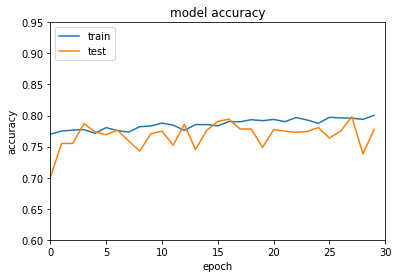

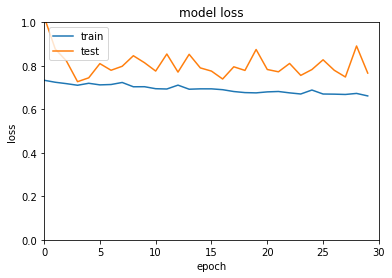

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.60,0.95)
plt.xlim(0,30)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.xlim(0,30)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Validación Externa

In [6]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/Mineria/Interna/datos/Modelos/Modelos/Raza_Segunda_vale_0.1_ResNet20v2_model.028.h5')

In [7]:
x_train_mean=np.mean(x_train,axis=0)
x_train-=x_train_mean
x_test-=x_train_mean
x_test2-=x_train_mean

In [8]:
scores=model.evaluate(x_test2,y_test2,verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.7651188969612122
Test accuracy: 0.7935045957565308
